<a href="https://colab.research.google.com/github/Aditya1Jhaveri/cervix-cancer-Deep-learning/blob/main/Efficientnet_b7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!git clone https://github.com/Aditya1Jhaveri/cervix-cancer-Deep-learning.git

Cloning into 'cervix-cancer-Deep-learning'...
remote: Enumerating objects: 23822, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 23822 (delta 18), reused 49 (delta 10), pack-reused 23760
Receiving objects: 100% (23822/23822), 753.85 MiB | 16.35 MiB/s, done.
Resolving deltas: 100% (61/61), done.
Updating files: 100% (23692/23692), done.


/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to /root/.cache/torch/hu

epoch,train_loss,valid_loss,accuracy,time
0,1.936841,1.442755,0.499281,01:33


epoch,train_loss,valid_loss,accuracy,time
0,1.381945,1.050848,0.599281,01:57
1,1.344714,0.928273,0.628777,02:03
2,1.189308,0.886579,0.643885,01:55
3,1.077164,0.843346,0.665468,01:55
4,1.033806,0.798117,0.697122,01:55
5,0.958617,0.751617,0.690647,01:55
6,0.921563,0.712733,0.720144,01:54
7,0.810747,0.669636,0.735971,01:54
8,0.729118,0.627500,0.743885,01:55
9,0.729806,0.573060,0.769065,01:57


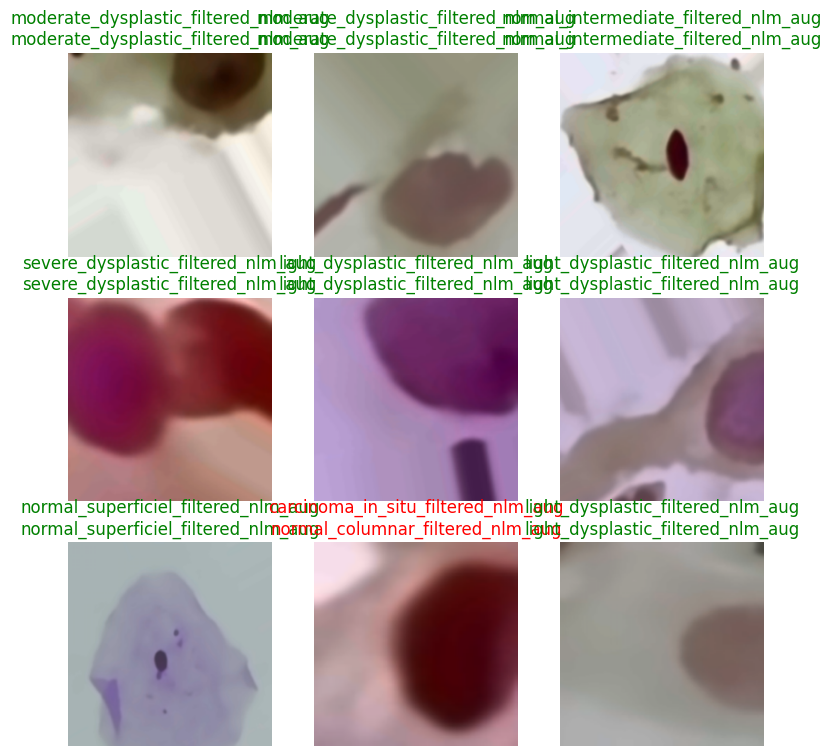

In [4]:
from fastai.vision.all import *

# Define the paths to your training and validation data
train_data_dir = '/content/cervix-cancer-Deep-learning/NLM Augmentation/train'
validation_data_dir = '/content/cervix-cancer-Deep-learning/NLM Augmentation/test'

# Set the image size and batch size
img_width, img_height = 224, 224
batch_size = 32

# Load the data using Fastai's DataLoaders
dls = ImageDataLoaders.from_folder(
    path=train_data_dir,
    train='/content/cervix-cancer-Deep-learning/NLM Augmentation/train',
    valid_pct=0.2,
    item_tfms=Resize(img_width),
    batch_tfms=[*aug_transforms(max_rotate=20, max_warp=0.2, p_affine=1.0, p_lighting=1.0), Normalize.from_stats(*imagenet_stats)],
    bs=batch_size
)

# Load the efficientnet_b0 architecture
arch = efficientnet_b7
learn = cnn_learner(dls, arch, metrics=[accuracy]).to_fp16()  # Use mixed-precision training

# Use gradient accumulation to reduce memory usage
learn.fine_tune(epochs=25, cbs=[GradientAccumulation(4)])

# Show results and plots
learn.show_results()




In [5]:

learn.save('efficientnet_b7 1')

Path('/content/cervix-cancer-Deep-learning/NLM Augmentation/train/models/efficientnet_b7 1.pth')

In [ ]:
# learn.load('efficientnet_b7 1')

# # Continue training for epochs 25 to 50
# learn.fine_tune(epochs=25, base_lr=1e-4, cbs=[GradientAccumulation(4)])

In [20]:
model_path = '/content/cervix-cancer-Deep-learning/NLM Augmentation/train/models/efficientnet_b7 1.pth'
learn = load_learner(model_path, cpu=False)


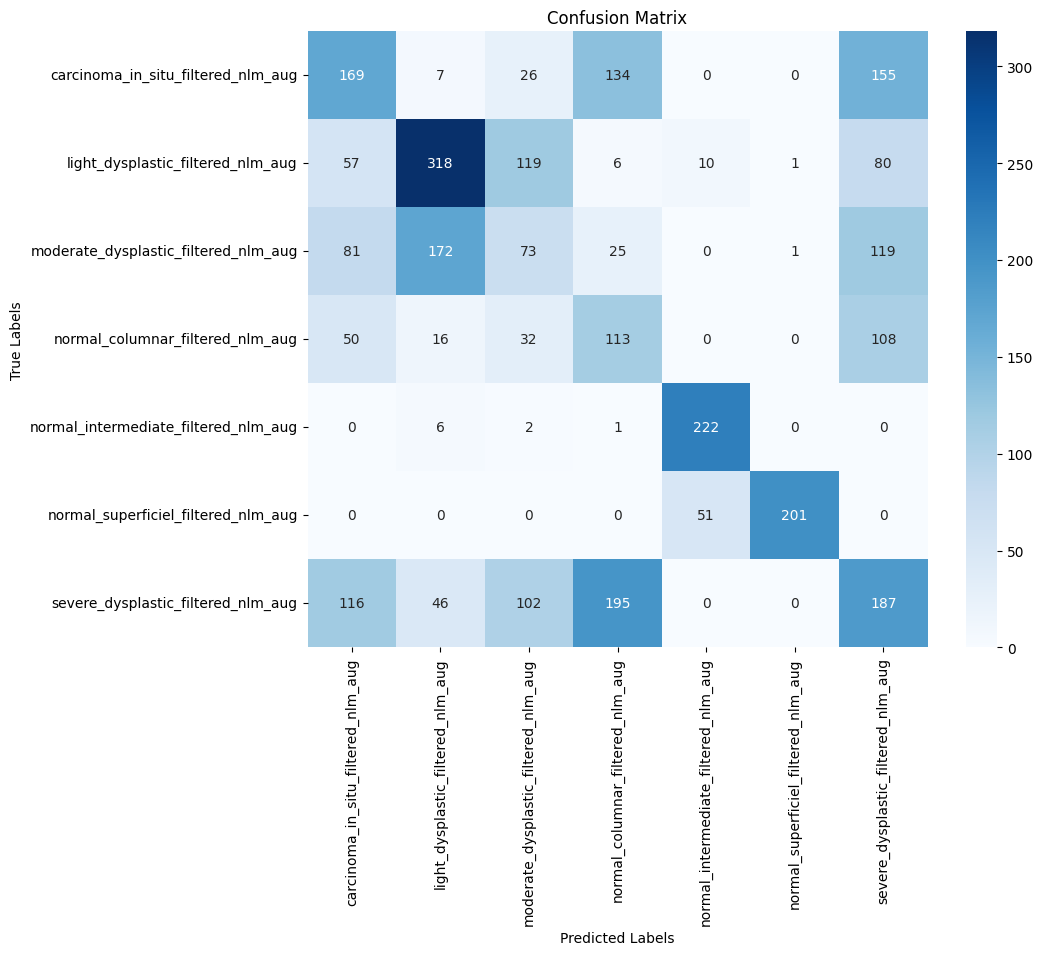

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the test data using Fastai's DataLoader
test_dls = dls.test_dl(
    get_image_files( '/content/cervix-cancer-Deep-learning/NLM Augmentation/test'),  # Replace with the actual path to your test data
    with_labels=True
)

# Get the model predictions on the test data
preds, _ = learn.get_preds(dl=test_dls)

# Convert the predictions to class indices
class_indices = preds.argmax(dim=1).numpy()

# Get the true class indices from the DataLoader
true_classes = [str(path).split('/')[-2] for path in test_dls.items]

# Map class names to numeric labels
class_to_idx = {class_name: idx for idx, class_name in enumerate(dls.vocab)}
true_indices = [class_to_idx[class_name] for class_name in true_classes]

# Generate the confusion matrix
confusion_mat = confusion_matrix(true_indices, class_indices)

# Plot the confusion matrix using seaborn
class_names = dls.vocab
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [28]:
from sklearn.metrics import accuracy_score

correct_predictions = (class_indices == true_indices).sum()
total_predictions = len(true_indices)
accuracy = correct_predictions / total_predictions

print(f"Test Accuracy: {accuracy:.2%}")

Test Accuracy: 42.75%
